# MORDM optimization

In [1]:
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import ema_logging, MultiprocessingEvaluator, Scenario, HypervolumeMetric
from ema_workbench.em_framework.optimization import (ArchiveLogger, EpsilonProgress, to_problem)

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [2]:
model, planning_steps = get_model_for_problem_formulation(2)

#The model requires a reference scenario to "kick-start"
reference_scenario = Scenario('reference', **{
    'discount rate-0': 1.5,
    'discount rate-1': 1.5,
    'discount rate-2': 1.5,
    'A.0_ID flood wave shape': 75,
    'A.1_Bmax': 240,
    'A.1_pfail': 0.25,
    'A.1_Brate': 10,
    'A.2_Bmax': 240,
    'A.2_pfail': 0.25,
    'A.2_Brate': 10,
    'A.3_Bmax': 240,
    'A.3_pfail': 0.25,
    'A.3_Brate': 10,
    'A.4_Bmax': 240,
    'A.4_pfail': 0.25,
    'A.4_Brate': 10,
    'A.5_Bmax': 240,
    'A.5_pfail': 0.25,
    'A.5_Brate': 10
})

In [3]:
convergence_metrics = [EpsilonProgress()]
nfe = 12000
epsilon = [0.5,0.5,0.5,0.01,0.01]
# Each epsilon value corresponds to a model outcome. The model outcomes are:
# expected damages, dike investment costs, rfr costs, evacuation cost, and casualties
# We select higher epsilon values to damages and costs, while we choose lower values for evacuation costs and casualties.

In [4]:
with MultiprocessingEvaluator(model) as evaluator:
    optimization_result = evaluator.optimize(nfe=nfe, searchover='levers', epsilons=epsilon,  convergence=convergence_metrics,reference=reference_scenario)

[MainProcess/INFO] pool started with 10 workers
12849it [04:10, 51.25it/s]                                                     
[MainProcess/INFO] optimization completed, found 495 solutions
[MainProcess/INFO] terminating pool


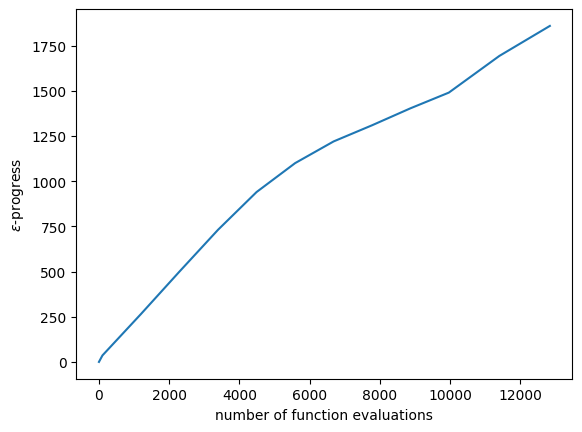

In [5]:
import matplotlib.pyplot as plt
import numpy as np
result, convergence = optimization_result
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

ax.set_xlabel('number of function evaluations')
plt.show()

In [6]:
from ema_workbench import save_results
#save_results(total, 'MORDM_100k_ep0.25.tar.gz'.format(nfe))

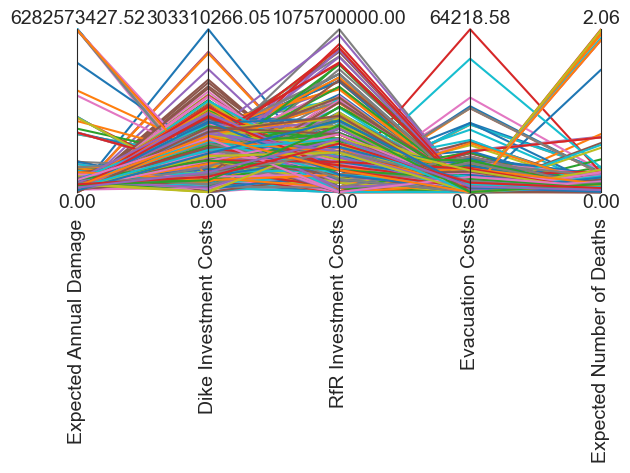

In [7]:
from ema_workbench.analysis import parcoords

data = result.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [8]:
# Select only those policies that result in an acceptable # of deaths
result_allowable_deaths = result[result['Expected Number of Deaths'] < 0.001]
result_allowable_deaths

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
5,0,0,0,0,0,0,0,1,1,0,...,0,3,6,0,0,0.000000e+00,1.973987e+08,61400000.0,0.000000,0.000000
15,1,0,1,0,0,0,0,0,0,0,...,0,3,7,0,0,0.000000e+00,1.645654e+08,169200000.0,0.000000,0.000000
21,1,0,1,0,0,0,1,0,1,0,...,0,3,6,0,0,0.000000e+00,1.606456e+08,230600000.0,0.000000,0.000000
24,1,0,1,0,0,0,0,0,0,0,...,0,0,5,0,0,0.000000e+00,1.417472e+08,290400000.0,0.000000,0.000000
30,0,0,0,0,0,0,0,0,0,0,...,2,0,10,0,0,0.000000e+00,3.033103e+08,0.0,0.000000,0.000000
65,0,0,0,0,0,0,0,1,0,0,...,0,0,7,0,0,0.000000e+00,2.040783e+08,30700000.0,0.000000,0.000000
68,1,0,1,0,0,0,0,1,1,1,...,3,3,4,0,0,5.478157e+06,1.335627e+08,594200000.0,68.133546,0.000898
73,0,0,0,0,0,0,0,0,0,0,...,3,0,6,0,0,1.386323e+06,2.610829e+08,0.0,0.000000,0.000380
74,0,0,0,0,0,0,0,0,0,0,...,1,0,10,0,0,5.703863e+06,2.601799e+08,0.0,116.415074,0.000404
105,0,0,0,0,0,0,0,0,0,0,...,3,0,6,0,0,4.910856e+06,2.094934e+08,0.0,152.241781,0.000155


In [9]:
# Remove columns for outcomes from the dataframe, resulting in a df of polcies
policies = result_allowable_deaths.drop([o.name for o in model.outcomes], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
5,0,0,0,0,0,0,0,1,1,0,...,0,5,0,0,5,0,3,6,0,0
15,1,0,1,0,0,0,0,0,0,0,...,0,6,0,0,6,0,3,7,0,0
21,1,0,1,0,0,0,1,0,1,0,...,0,6,0,0,6,0,3,6,0,0
24,1,0,1,0,0,0,0,0,0,0,...,0,6,0,0,7,0,0,5,0,0
30,0,0,0,0,0,0,0,0,0,0,...,0,6,0,0,5,2,0,10,0,0
65,0,0,0,0,0,0,0,1,0,0,...,0,5,0,0,5,0,0,7,0,0
68,1,0,1,0,0,0,0,1,1,1,...,0,3,0,0,3,3,3,4,0,0
73,0,0,0,0,0,0,0,0,0,0,...,0,6,0,0,4,3,0,6,0,0
74,0,0,0,0,0,0,0,0,0,0,...,0,6,0,0,5,1,0,10,0,0
105,0,0,0,0,0,0,0,0,0,0,...,0,6,0,0,3,3,0,6,0,0


In [10]:
#### here: create the data folder33

convergence_metrics = [
    ArchiveLogger(
        "./MORDM_Data",
        [l.name for l in model.levers],
        [o.name for o in model.outcomes],
        base_filename="MORDM_HV_1.tar.gz",
    ),
    EpsilonProgress(),
]

with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize(nfe=nfe, searchover='levers', epsilons=epsilon,  convergence=convergence_metrics,reference=reference_scenario)

[MainProcess/INFO] pool started with 10 workers
12787it [04:02, 52.64it/s]                                                     
[MainProcess/INFO] optimization completed, found 490 solutions
[MainProcess/INFO] terminating pool


In [11]:
archives = ArchiveLogger.load_archives("./MORDM_Data/MORDM_HV_1.tar.gz")

In [12]:
from copy import deepcopy

results_sanitized = results.copy()
model_sanitized = deepcopy(model)

# Here, we need to rename...
def sanitize_as_python_identifier(x):
    # Replace dots
    x = x.replace(".","Ç")
    # Replace spaces
    x = x.replace(" ","Ñ")
    # Add letter if starts with digit
    if x.startswith(("0","1","2","3","4","5")):
        x = "A" + x
    return x

# Reverse functions for if we need to get the labels...
def desanitize_as_python_identifier(x):
    # Replace dots
    x = x.replace("Ç",".")
    # Replace spaces
    x = x.replace("Ñ"," ")
    # Add letter if starts with digit
    if x.startswith(("A0","A1","A2","A3","A4","A5")):
        x = x[1:]
    return x

results_sanitized.columns = [sanitize_as_python_identifier(x) for x in results.columns]

for lev in model_sanitized.levers:
    lev.name = sanitize_as_python_identifier(lev.name)

for unc in model_sanitized.uncertainties:
    unc.name = sanitize_as_python_identifier(unc.name)

for out in model_sanitized.outcomes:
    out.name = sanitize_as_python_identifier(out.name)

In [ ]:
reference_set = results_sanitized
problem = to_problem(model_sanitized, searchover="levers")

hv = HypervolumeMetric(reference_set, problem)

hypervolume = []
for nfe, archive in archives.items():
    archive_sanitized = archive
    archive_sanitized.columns = [sanitize_as_python_identifier(x) for x in archive_sanitized.columns]
    the_result = (nfe, hv.calculate(archive))
    hypervolume.append(the_result)

hypervolume.sort(key=lambda x:x[0])
hypervolume = np.asarray(hypervolume)


In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(hypervolume[:, 0], hypervolume[:, 1])
ax2.set_ylim(ymin=0)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

## Parcoords

In [ ]:
from ema_workbench.analysis import parcoords

print([o.name for o in model.outcomes])

data = result.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

Filtering the found solutions to those that are most important for the Delta Commission.

In [ ]:
from ema_workbench.analysis import parcoords

data = result_allowable_deaths.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()